# EKG Quality Walkthrough (TDMS, 512 Hz)

Denne notebook guider dig trin-for-trin gennem:
1) Indlæsning af **TDMS**-optagelser (valgfrit også index/meta-TDMS),
2) Valg af gruppe/kanal og udlæsning af samplingsfrekvens,
3) Basisfiltrering (0.5–40 Hz + 50 Hz notch),
4) Klassiske **SQI'er** per vindue,
5) **Modulations-spektret** og et **MSQI**,
6) Simpel **modulation-domain denoising**,
7) R-peak detektion før/efter og eksport af resultater.

> **Tip:** Kør cellerne én for én. Læs markdownen over hver celle for at forstå, hvad der sker.


## 0) Opsætning af miljø

Kør dette **én gang** for at sikre nødvendige pakker er installeret i dit aktuelle miljø.


In [53]:
# Hvis du kører i et miljø uden disse pakker, så fjern kommentartegnet på næste linje:
# !python -m pip install numpy scipy pandas matplotlib neurokit2 nptdms openpyxl


## 1) Konfiguration: stier og parametre

**Tilpas disse felter** til din maskine:
- `TDMS_PATH` → sti til din optagelse (`.tdms`)
- `TDMS_INDEX_PATH` → (valgfri) sti til index/meta-tdms
- `TDMS_GROUP` / `TDMS_CHANNEL` → hvis din EKG-kanal ikke ligger som den første
- `FS_OVERRIDE` → sæt til `512.0` hvis sampling ikke kan udledes automatisk


In [54]:
from pathlib import Path

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# TILPAS HER:
TDMS_PATH = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms") 
TDMS_INDEX_PATH = None  # Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1_index.tdms")
TDMS_GROUP = None       # fx "GroupName" eller None
TDMS_CHANNEL = None     # fx "ChannelName" eller None
FS_OVERRIDE = None      # fx 512.0 hvis sampling ikke kan udledes
OUT_DIR = Path(r"E:\Speciale\Log") / "results_notebook"
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Output dir:", OUT_DIR)

Output dir: E:\Speciale\Log\results_notebook


## 2) Importer funktioner

Hjælpefunktioner til indlæsning (TDMS/TDMS+index), filtrering, vinduesinddeling, SQI'er, modulations-spektret, MSQI og denoising.


In [55]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch, stft, istft
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

def load_tdms(path_tdms, group=None, channel=None):
    from nptdms import TdmsFile
    td = TdmsFile.read(str(path_tdms))
    g = td.groups()[0] if group is None else td[group]
    ch = g.channels()[0] if channel is None else g[channel]
    x = ch.data.astype(float)
    fs = None
    inc = ch.properties.get("wf_increment", None)
    if inc is not None:
        try:
            fs = float(1.0/float(inc))
        except Exception:
            fs = None
    return x, fs, td

def load_tdms_with_index(path_tdms, path_index, group=None, channel=None):
    from nptdms import TdmsFile
    td = TdmsFile.read(str(path_tdms))
    g = td.groups()[0] if group is None else td[group]
    ch = g.channels()[0] if channel is None else g[channel]
    x = ch.data.astype(float)
    info = {}
    with TdmsFile.open(str(path_index)) as idx:
        for group_obj in idx.groups():
            for ch_obj in group_obj.channels():
                for prop, val in ch_obj.properties.items():
                    info[prop] = val
    fs = None
    inc = info.get("wf_increment", None)
    if inc is None:
        inc = ch.properties.get("wf_increment", None)
    if inc is not None:
        try:
            fs = float(1.0/float(inc))
        except Exception:
            fs = None
    return x, fs, td, info

def bandpass_notch(x, fs, low=0.5, high=40.0, order=4, notch_f0=50.0, notch_Q=30.0):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    y = filtfilt(b, a, x)
    b2, a2 = iirnotch(w0=notch_f0, Q=notch_Q, fs=fs)
    y = filtfilt(b2, a2, y)
    return y

def window_slices(N, fs, win_s=10.0, hop_s=5.0):
    win = int(round(win_s*fs))
    hop = int(round(hop_s*fs))
    if win <= 0:
        raise ValueError("Window length too small")
    idx = []
    for start in range(0, max(1, N - win + 1), hop):
        idx.append((start, start+win))
    if not idx or idx[-1][1] < N:
        start = max(0, N - win)
        idx.append((start, start+win))
    return idx

def energy_ratio_qrs(seg, fs, qrs_lo=5.0, qrs_hi=15.0):
    b, a = butter(4, [qrs_lo/(fs/2), qrs_hi/(fs/2)], btype='band')
    q = filtfilt(b, a, seg)
    num = np.mean(q**2)
    den = np.mean(seg**2) + 1e-12
    return float(num/den)

def baseline_wander_index(seg, fs, cutoff=0.7):
    b, a = butter(4, cutoff/(fs/2), btype='low')
    low = filtfilt(b, a, seg)
    return float(np.mean(low**2)/(np.mean(seg**2)+1e-12))

def powerline_index(seg, fs, mains=50.0, Q=35.0):
    b, a = iirnotch(mains, Q, fs)
    y = filtfilt(b, a, seg)
    removed = np.mean((seg - y)**2)
    total = np.mean(seg**2) + 1e-12
    return float(removed/total)

def modulation_spectrogram_mag(S_mag, hop_s, fs, nperseg):
    T = S_mag.shape[1]
    M_full = np.fft.rfft(S_mag, axis=1)  # [freq_bins x (T//2+1)]
    M = np.abs(M_full).T                 # [f_mod x f_car]
    frame_rate = (1.0/hop_s)  # frames per second
    f_mod = np.fft.rfftfreq(T, d=1.0/frame_rate)
    f_car = None
    return M, f_mod, f_car

def compute_msqi(x, fs, nperseg=1024, noverlap=None, carrier_lo=5.0, carrier_hi=40.0, mod_lo=0.5, mod_hi=3.0):
    if noverlap is None:
        noverlap = nperseg // 2
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann', padded=True, boundary='zeros')
    S_mag = np.abs(Z)
    hop = nperseg - noverlap
    hop_s_est = hop / fs
    M, f_mod, _ = modulation_spectrogram_mag(S_mag, hop_s_est, fs, nperseg)
    f_car = f
    car_mask = (f_car >= carrier_lo) & (f_car <= carrier_hi)
    mod_mask = (f_mod >= mod_lo) & (f_mod <= mod_hi)
    signal_region = np.mean(M[np.ix_(mod_mask, car_mask)])
    noise_region = np.mean(M[~mod_mask][:, car_mask]) if np.any(~mod_mask) else 1e-12
    msqi_global = float(signal_region / (noise_region + 1e-12))
    return msqi_global, (M, f_mod, f_car, f)

def modulation_denoise(x, fs, nperseg=1024, noverlap=None, carrier_lo=5.0, carrier_hi=40.0, mod_lo=0.5, mod_hi=3.0, softness=0.6):
    if noverlap is None:
        noverlap = nperseg // 2
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann', padded=True, boundary='zeros')
    S = Z.copy()
    S_mag = np.abs(S)
    hop = nperseg - noverlap
    hop_s_est = hop / fs
    M_complex = np.fft.rfft(S_mag, axis=1)
    f_mod = np.fft.rfftfreq(S_mag.shape[1], d=hop_s_est)
    car_mask = (f >= carrier_lo) & (f <= carrier_hi)
    mod_mask = (f_mod >= mod_lo) & (f_mod <= mod_hi)
    M = np.abs(M_complex)
    Mask_mod = np.zeros_like(M)
    Mask_mod[np.ix_(mod_mask, car_mask)] = 1.0
    Mask_mod = (1 - softness) + softness * Mask_mod
    M_denoised = M_complex * Mask_mod
    S_mag_denoised = np.fft.irfft(M_denoised, n=S_mag.shape[1], axis=1)
    S_denoised = S_mag_denoised * np.exp(1j*np.angle(S))
    _, x_rec = istft(S_denoised, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann')
    x_rec = x_rec[:len(x)]
    return x_rec


## 3) Indlæs data og inspicér TDMS-struktur

- Vi indlæser `.tdms` (og evt. `.tdms_index.tdms`),
- Udskriver **groups** og **channels**,
- Udleder samplingsfrekvens (`fs`) automatisk eller bruger `FS_OVERRIDE`.


In [56]:
from nptdms import TdmsFile

if TDMS_INDEX_PATH is not None:
    x_raw, fs_infer, td, meta = load_tdms_with_index(TDMS_PATH, TDMS_INDEX_PATH, TDMS_GROUP, TDMS_CHANNEL)
else:
    x_raw, fs_infer, td = load_tdms(TDMS_PATH, TDMS_GROUP, TDMS_CHANNEL)
    meta = {}

print("Infered fs from TDMS:", fs_infer)
fs = FS_OVERRIDE if FS_OVERRIDE is not None else fs_infer
if fs is None:
    raise ValueError("Kunne ikke udlede sampling; sæt FS_OVERRIDE = 512.0 (eller korrekt værdi).")
fs = float(fs)
print("Using fs:", fs)

print("Groups:", [g.name for g in td.groups()])
g0 = td.groups()[0]
print("Channels in first group:", [ch.name for ch in g0.channels()])

N = len(x_raw)
print("Samples:", N, "Duration [s]:", N/fs)

Infered fs from TDMS: 512.0
Using fs: 512.0
Groups: ['Untitled']
Channels in first group: ['EKG']
Samples: 32708992 Duration [s]: 63884.75


In [59]:
# --- Hent starttid fra TDMS og lav tidsstempler ---
# Forsøg: wf_start_time i kanal-/index-egenskaber. Hvis ikke, brug relative tider.

def try_get_start_time(td, index_path=None):
    from nptdms import TdmsFile
    # kig i første gruppe/kanal
    g0 = td.groups()[0]
    ch0 = g0.channels()[0]
    props = dict(ch0.properties.items())
    wf_start = props.get("wf_start_time", None)
    if (wf_start is None) and (index_path is not None):
        try:
            with TdmsFile.open(str(index_path)) as idx:
                for group_obj in idx.groups():
                    for ch_obj in group_obj.channels():
                        if "wf_start_time" in ch_obj.properties:
                            wf_start = ch_obj.properties["wf_start_time"]
                            break
        except Exception:
            pass
    return wf_start  # kan være None

wf_start_time = try_get_start_time(td, TDMS_INDEX_PATH)
if wf_start_time is not None:
    # Byg tidsakse i ns opløsning ud fra fs
    N = len(x_raw)
    dt_ns = int(round(1e9 / fs))
    start_np = np.datetime64(wf_start_time, "ns")
    timestamps = start_np + np.arange(N) * np.timedelta64(dt_ns, "ns")
    print("Absolutte timestamps oprettet fra wf_start_time.")
else:
    timestamps = None
    print("Fandt ikke wf_start_time. Brug relative tider (sekunder fra start).")

# --- Indlæs anfaldsannoteringer (Excel) + DST-korrektion ---
SEIZURE_XLSX_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures\Patient 2.xls"   # <-- SKIFT STIEN

import pandas as pd
def load_seizure_excel(path):
    # Læs hele arket (tilpas skiprows/sheet_name hvis du kender formatet)
    df = pd.read_excel(path)  # evt. sheet_name=..., skiprows=...
    # Find en tidskolonne (prøv almindelige navne; ellers vælg første datetime-lignende)
    candidates = [c for c in df.columns if str(c).lower() in ["time","timestamp","datetime","anfald","anfaldstid","start","start_time"]]
    if candidates:
        col = candidates[0]
    else:
        # heuristik: vælg første kolonne med datetime dtype efter parsing
        for c in df.columns:
            try:
                parsed = pd.to_datetime(df[c], errors="coerce")
                if parsed.notna().sum() > 0:
                    df[c] = parsed
                    col = c
                    break
            except Exception:
                continue
        else:
            raise ValueError("Kunne ikke finde en datetime-kolonne i excel-arket.")
    # Sørg for datetime dtype
    df[col] = pd.to_datetime(df[col], errors="coerce")
    df = df[df[col].notna()].copy()
    df.rename(columns={col: "SeizureTime"}, inplace=True)
    return df[["SeizureTime"]].reset_index(drop=True)

seizures = load_seizure_excel(SEIZURE_XLSX_PATH)
print("Antal anfald i excel:", len(seizures))

# DST-korrektion (som i din kode; fixed lister for EU dst)
import numpy as np

summertime_np = np.array([
    "2010-03-28T02:00", "2011-03-27T02:00", "2012-03-25T02:00", "2013-03-31T02:00", "2014-03-30T02:00",
    "2015-03-29T02:00", "2016-03-27T02:00", "2017-03-26T02:00", "2018-03-25T02:00", "2019-03-31T02:00",
    "2020-03-29T02:00", "2021-03-28T02:00", "2022-03-27T02:00", "2023-03-26T02:00", "2024-03-31T02:00"
], dtype='datetime64[m]')

wintertime_np = np.array([
    "2010-10-31T03:00", "2011-10-30T03:00", "2012-10-28T03:00", "2013-10-27T03:00", "2014-10-26T03:00",
    "2015-10-25T03:00", "2016-10-30T03:00", "2017-10-29T03:00", "2018-10-28T03:00", "2019-10-27T03:00",
    "2020-10-25T03:00", "2021-10-31T03:00", "2022-10-30T03:00", "2023-10-29T03:00", "2024-10-27T03:00"
], dtype='datetime64[m]')

def correct_annotation_timestamp_np(anfalds_tidspunkt: np.datetime64) -> np.datetime64:
    year = int(str(anfalds_tidspunkt)[:4])
    # find index
    idx = None
    for i in range(len(summertime_np)):
        if str(summertime_np[i])[:4] == str(year):
            idx = i; break
    if idx is None:
        # hvis år ligger udenfor listerne, returnér som UTC-naiv
        return anfalds_tidspunkt
    start_summer = summertime_np[idx]
    start_winter = wintertime_np[idx]
    if start_summer <= anfalds_tidspunkt < start_winter:
        return anfalds_tidspunkt - np.timedelta64(2, 'h')  # summer: UTC+2
    else:
        return anfalds_tidspunkt - np.timedelta64(1, 'h')  # winter: UTC+1

# Anvend DST-korrektion
seizures["SeizureTime_corr"] = seizures["SeizureTime"].astype("datetime64[ns]").apply(lambda t: correct_annotation_timestamp_np(np.datetime64(t)))
seizures.head()


Absolutte timestamps oprettet fra wf_start_time.
Antal anfald i excel: 11


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_24972\3612881233.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[c], errors="coerce")
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_24972\3612881233.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[c], errors="coerce")


,SeizureTime,SeizureTime_corr
0,1970-01-01 00:00:00.000000001,1970-01-01
1,1970-01-01 00:00:00.000000002,1970-01-01
2,1970-01-01 00:00:00.000000003,1970-01-01
3,1970-01-01 00:00:00.000000004,1970-01-01
4,1970-01-01 00:00:00.000000005,1970-01-01


In [ ]:
# --- Hjælpere til mapping og profiler omkring anfald ---
def time_to_sample_idx(t_query, timestamps, fs, N):
    """
    t_query: np.datetime64 (hvis vi har absolute timestamps) ELLER float sekunder (hvis ikke).
    timestamps: np.ndarray af np.datetime64 eller None
    fs, N: sampling og længde
    Returnerer nærmeste sampleindeks.
    """
    if timestamps is not None and np.issubdtype(type(t_query), np.datetime64):
        # binær søgning
        idx = np.searchsorted(timestamps, t_query)
        idx = int(np.clip(idx, 0, N-1))
        return idx
    else:
        # antag at t_query er sekunder fra start
        s = float(t_query)
        idx = int(np.clip(round(s*fs), 0, N-1))
        return idx

# Vælg tidsvindue omkring anfald (sekunder)
pre_s  = 5*60   # 5 min før
post_s = 5*60   # 5 min efter

# Byg en tidsakse til profiler (i sekunder relativt til anfald)
prof_t = np.arange(-pre_s, post_s+1)

# Aggreger vindues-metrikker til en tidsserie (sekund-opløsning) for nem alignment
# Vi bruger msqi_window og quality_score, men du kan tilføje flere.
win_mid = 0.5*(df_scores["start_s"].values + df_scores["end_s"].values)

def to_series(x_time, x_value, step_s=1.0):
    # resampler til 1 Hz ved nærmeste-neighbour (simpelt)
    t_grid = np.arange(0, int(np.ceil(t_all[-1]))+1)
    # map via nærmeste indeks
    idx = np.clip(np.searchsorted(t_grid, x_time), 0, len(t_grid)-1)
    y = np.full_like(t_grid, np.nan, dtype=float)
    # hvis flere værdier rammer samme sekund, brug middel
    import pandas as pd
    df_tmp = pd.DataFrame({"t": t_grid[idx], "v": x_value})
    agg = df_tmp.groupby("t")["v"].mean()
    y[agg.index] = agg.values
    return t_grid, y

t_grid, msqi_series   = to_series(win_mid, df_scores["msqi_window"].values)
_,     qscore_series  = to_series(win_mid, df_scores["quality_score"].values)

def extract_profile_at_event(event_idx, series, fs, t_grid, pre_s, post_s, timestamps=None):
    """
    event_idx: sampleindeks i rå signal
    series: sekund-opløst serie (længde ~ total sekunder)
    Returnerer vektor med længde pre_s+post_s+1 justeret til eventtid.
    """
    # eventtid i sekunder fra start:
    ev_t_s = event_idx / fs
    ev_sec_idx = int(np.clip(round(ev_t_s), 0, len(series)-1))
    a = max(0, ev_sec_idx - pre_s)
    b = min(len(series), ev_sec_idx + post_s + 1)
    prof = np.full(pre_s+post_s+1, np.nan)
    prof[(pre_s - (ev_sec_idx-a)) : (pre_s + (b-ev_sec_idx))] = series[a:b]
    return prof

# Saml profiler for alle anfald
profiles_msqi  = []
profiles_qsc   = []

for _, row in seizures.iterrows():
    if timestamps is not None:
        t_event = np.datetime64(row["SeizureTime_corr"])
        ev_idx = time_to_sample_idx(t_event, timestamps, fs, N)
    else:
        # uden absolut tid: antag SeizureTime er "sekunder fra start"
        # (tilpas hvis din excel indeholder relative tider i stedet)
        ev_idx = time_to_sample_idx(row["SeizureTime"].timestamp(), None, fs, N)

    prof_msqi = extract_profile_at_event(ev_idx, msqi_series,  fs, t_grid, pre_s, post_s, timestamps)
    prof_qsc  = extract_profile_at_event(ev_idx, qscore_series, fs, t_grid, pre_s, post_s, timestamps)
    profiles_msqi.append(prof_msqi)
    profiles_qsc.append(prof_qsc)

import numpy as np
profiles_msqi  = np.array(profiles_msqi) if profiles_msqi else np.empty((0, pre_s+post_s+1))
profiles_qsc   = np.array(profiles_qsc)  if profiles_qsc else np.empty((0, pre_s+post_s+1))

# Plot gennemsnitsprofiler +/- 1 std
def plot_profile(mean_prof, all_prof, title):
    plt.figure(figsize=(10,4))
    m = np.nanmean(all_prof, axis=0)
    s = np.nanstd(all_prof, axis=0)
    plt.plot(prof_t, m, label="mean")
    plt.fill_between(prof_t, m-s, m+s, alpha=0.2, label="±1 std")
    plt.axvline(0, color='k', linestyle='--', alpha=0.6)
    plt.xlabel("Time from seizure (s)")
    plt.title(title)
    plt.legend()
    plt.show()

if profiles_msqi.size > 0:
    plot_profile(np.nanmean(profiles_msqi, axis=0), profiles_msqi, "MSQI around seizures")
if profiles_qsc.size > 0:
    plot_profile(np.nanmean(profiles_qsc, axis=0), profiles_qsc, "Quality score around seizures")


KeyError: 'msqi_window'

## 4) Plot et kort udsnit af rå EKG

Hjælper med at sanity-checke amplitude og indhold.


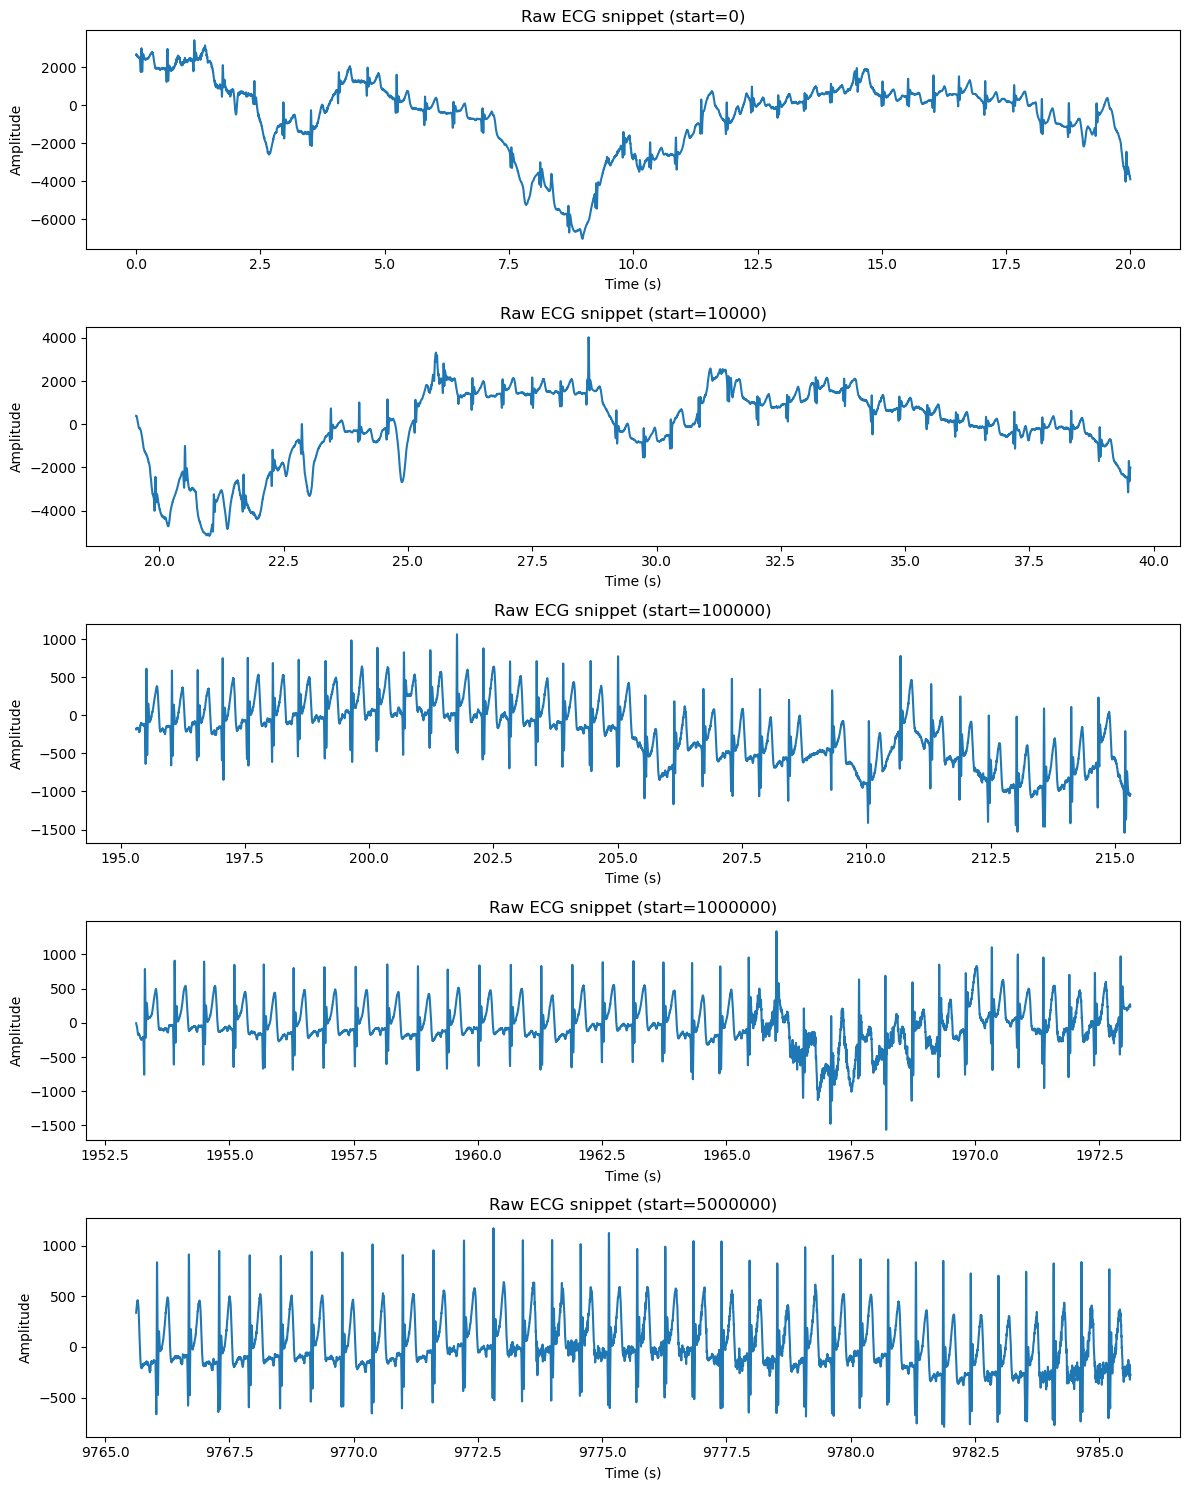

In [ ]:
start_points = [0, 10000, 100000, 1000000, 5000000]
sec = 20
L = int(sec * fs)

plt.figure(figsize=(12, len(start_points) * 3))
for i, start in enumerate(start_points):
    end = min(N, start + L)
    t = np.arange(start, end) / fs

    plt.subplot(len(start_points), 1, i + 1)
    plt.plot(t, x_raw[start:end])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Raw ECG snippet (start={start})")

plt.tight_layout()
plt.show()

## 5) Basisfiltrering (0.5–40 Hz bandpass + 50 Hz notch)

Reducerer baseline wander, højfrekvent støj og elnetstøj.


c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


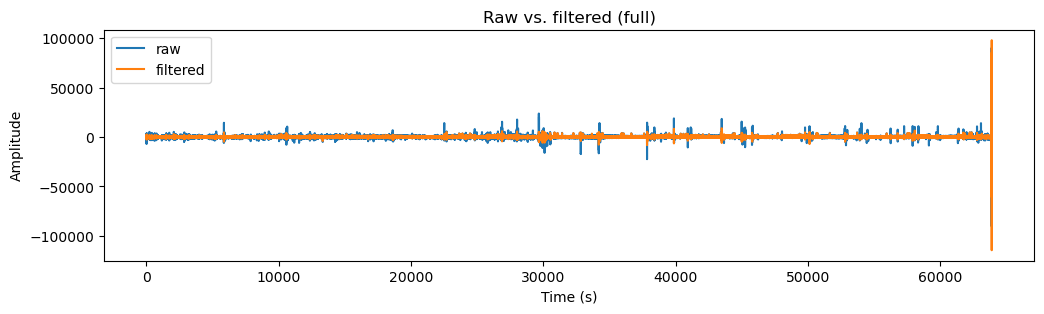

In [ ]:
x_f = bandpass_notch(x_raw, fs)
plt.figure(figsize=(12,3))
t_all = np.arange(N)/fs
plt.plot(t_all, x_raw, label="raw")
plt.plot(t_all, x_f, label="filtered")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw vs. filtered (full)")
plt.legend()
plt.show()

## 6) Vinduer og klassiske SQI'er

Vi beregner pr. 10 s vindue (50% overlap er typisk godt; her kan du justere `win_s` og `hop_s`).


In [ ]:
win_s = 100.0
hop_s = 5.0
slices = window_slices(N, fs, win_s=win_s, hop_s=hop_s)
len(slices), slices[:3]

(12758, [(0, 51200), (2560, 53760), (5120, 56320)])

In [ ]:
rows = []
for (a,b) in slices:
    seg = x_f[a:b]
    er = energy_ratio_qrs(seg, fs)
    kur = float(kurtosis(seg, fisher=True, bias=False))
    bwi = baseline_wander_index(seg, fs)
    pli = powerline_index(seg, fs)
    rows.append({"start_s": a/fs, "end_s": b/fs, "sqi_energy_qrs": er, "sqi_kurtosis": kur, "sqi_baseline": bwi, "sqi_powerline": pli})

df_scores = pd.DataFrame(rows)
df_scores.head()

,start_s,end_s,sqi_energy_qrs,sqi_kurtosis,sqi_baseline,sqi_powerline
0,0.0,100.0,0.069437,4.807683,0.087800,6.366708e-07
1,5.0,105.0,0.071933,5.377225,0.090203,4.434591e-07
2,10.0,110.0,0.079109,6.288935,0.077283,4.708107e-07
3,15.0,115.0,0.083817,6.951545,0.071692,1.086880e-06
4,20.0,120.0,0.087132,7.507900,0.073618,5.243733e-07


In [ ]:
# --- MSQI per vindue (samme vinduesinddeling som df_scores) ---
# Vi genbruger compute_msqi på hvert vindue (simpelt, lidt tungere men gennemsigtigt).
# Du kan tune parametre: nperseg, noverlap, carrier/mod-bånd.

def msqi_on_segment(seg, fs,
                    nperseg=1024, noverlap=None,
                    carrier_lo=5.0, carrier_hi=40.0,
                    mod_lo=0.5, mod_hi=3.0):
    if noverlap is None:
        noverlap = nperseg // 2
    from scipy.signal import stft
    f, t, Z = stft(seg, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann', padded=True, boundary='zeros')
    S_mag = np.abs(Z)
    hop = nperseg - noverlap
    hop_s_est = hop / fs
    # modulation
    M_full = np.fft.rfft(S_mag, axis=1)        # [freq x fmod_bins]
    M = np.abs(M_full).T                        # [f_mod x f_car]
    f_mod = np.fft.rfftfreq(S_mag.shape[1], d=hop_s_est)
    f_car = f
    car_mask = (f_car >= carrier_lo) & (f_car <= carrier_hi)
    mod_mask = (f_mod >= mod_lo) & (f_mod <= mod_hi)
    signal_region = np.mean(M[np.ix_(mod_mask, car_mask)])
    noise_region = np.mean(M[~mod_mask][:, car_mask]) if np.any(~mod_mask) else 1e-12
    return float(signal_region / (noise_region + 1e-12))

msqi_list = []
for (a, b) in slices:
    seg = x_f[a:b]
    msqi_list.append(msqi_on_segment(seg, fs))

df_scores["msqi_window"] = msqi_list
df_scores.head()


In [ ]:
# --- Enkel samlescore og labels ---
# Normaliser (z) og lav en simpel kompositscore:
# høj QRS-energi og høj MSQI = godt; høj baseline/powerline = dårligt.
from scipy.stats import zscore

tmp = df_scores.copy()
for col in ["sqi_energy_qrs", "sqi_baseline", "sqi_powerline", "msqi_window"]:
    tmp[col+"_z"] = zscore(tmp[col].values, nan_policy='omit')

# Kompositscore (kan tweakes):
# god_score = QRS + MSQI - Baseline - Powerline
tmp["quality_score"] = tmp["sqi_energy_qrs_z"] + tmp["msqi_window_z"] - tmp["sqi_baseline_z"] - tmp["sqi_powerline_z"]

# Label via percentiler (kan tweakes, fx bedst 25% = 'good', værst 25% = 'bad')
good_thr = np.nanpercentile(tmp["quality_score"], 75)
bad_thr  = np.nanpercentile(tmp["quality_score"], 25)
tmp["label"] = "ok"
tmp.loc[tmp["quality_score"] >= good_thr, "label"] = "good"
tmp.loc[tmp["quality_score"] <= bad_thr,  "label"] = "bad"

df_scores = tmp  # overwrite

# --- Plot eksempelvinduer ---
def plot_window(a, b, title):
    t = np.arange(a, b) / fs
    plt.figure(figsize=(12,3))
    plt.plot(t, x_f[a:b])
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Vælg 3 "good" og 3 "bad" vinduer
good_idx = df_scores.index[df_scores["label"]=="good"][:3]
bad_idx  = df_scores.index[df_scores["label"]=="bad"][:3]

for i in good_idx:
    a = int(df_scores.loc[i, "start_s"]*fs)
    b = int(df_scores.loc[i, "end_s"]*fs)
    plot_window(a, b, f"GOOD window (score={df_scores.loc[i, 'quality_score']:.2f})")

for i in bad_idx:
    a = int(df_scores.loc[i, "start_s"]*fs)
    b = int(df_scores.loc[i, "end_s"]*fs)
    plot_window(a, b, f"BAD window (score={df_scores.loc[i, 'quality_score']:.2f})")

# --- Tidskurver for SQI'er + labels (hurtigt overblik) ---
mid_t = 0.5*(df_scores["start_s"].values + df_scores["end_s"].values)

plt.figure(figsize=(12,4))
plt.plot(mid_t, df_scores["sqi_energy_qrs"], label="QRS energy")
plt.plot(mid_t, df_scores["msqi_window"], label="MSQI (window)")
plt.legend(); plt.xlabel("Time (s)"); plt.title("Quality metrics over time")
plt.show()

plt.figure(figsize=(12,2))
colors = df_scores["label"].map({"good":"g","bad":"r","ok":"gray"}).values
plt.scatter(mid_t, np.zeros_like(mid_t), c=colors, s=8)
plt.yticks([])
plt.xlabel("Time (s)")
plt.title("Window labels (good/ok/bad)")
plt.show()


In [ ]:
# Find the indices of the maximum values for each variable
max_indices = {
    "sqi_energy_qrs": df_scores["sqi_energy_qrs"].idxmax(),
    "sqi_kurtosis": df_scores["sqi_kurtosis"].idxmax(),
    "sqi_baseline": df_scores["sqi_baseline"].idxmax(),
    "sqi_powerline": df_scores["sqi_powerline"].idxmax(),
}

print(max_indices)

# Get the start_s and end_s for the windows with the maximum values
max_windows = {
    col: (df_scores.loc[idx, "start_s"], df_scores.loc[idx, "end_s"])
    for col, idx in max_indices.items()
}

print(max_windows)

# Display the highlighted dataframe
display_dataframe_to_user("Highlighted Window Scores (Max Values)", df_scores_highlighted)

{'sqi_energy_qrs': 12755, 'sqi_kurtosis': 12754, 'sqi_baseline': 6564, 'sqi_powerline': 12754}
{'sqi_energy_qrs': (np.float64(63775.0), np.float64(63875.0)), 'sqi_kurtosis': (np.float64(63770.0), np.float64(63870.0)), 'sqi_baseline': (np.float64(32820.0), np.float64(32920.0)), 'sqi_powerline': (np.float64(63770.0), np.float64(63870.0))}
Start time of patient measurement (seconds): 0.0
Highlighted Window Scores (Max Values)


,start_s,end_s,sqi_energy_qrs,sqi_kurtosis,sqi_baseline,sqi_powerline
0,0.00,100.00,0.069437,4.807683,0.0878,0.000001
1,5.00,105.00,0.071933,5.377225,0.090203,0.0
2,10.00,110.00,0.079109,6.288935,0.077283,0.0
3,15.00,115.00,0.083817,6.951545,0.071692,0.000001
4,20.00,120.00,0.087132,7.5079,0.073618,0.000001
...,...,...,...,...,...,...
12753,63765.00,63865.00,0.10649,1.377059,0.013433,0.000001
12754,63770.00,63870.00,0.16152,**391.224029330516**,0.149931,**8.654783118209313e-05**
12755,63775.00,63875.00,**0.31384119871616034**,94.226984,0.023909,0.000018
12756,63780.00,63880.00,0.297057,68.4772,0.027626,0.000016


In [ ]:
# Shim til at efterligne caas_jupyter_tools.display_dataframe_to_user
def display_dataframe_to_user(name: str, dataframe):
    from IPython.display import display, HTML
    print(name)
    display(dataframe)


Vis tabellen i et interaktivt grid (kan scrolle og sortere).


In [ ]:
display_dataframe_to_user("Window scores (classic SQIs)", df_scores)

Window scores (classic SQIs)


,start_s,end_s,sqi_energy_qrs,sqi_kurtosis,sqi_baseline,sqi_powerline
0,0.00,10.00,0.042846,0.393203,0.066476,5.092333e-07
1,5.00,15.00,0.035632,0.702681,0.165267,3.376403e-06
2,10.00,20.00,0.049207,2.048168,0.164570,3.406461e-07
3,15.00,25.00,0.029706,1.370825,0.053807,1.201127e-06
4,20.00,30.00,0.032609,1.907240,0.099210,2.070540e-07
...,...,...,...,...,...,...
12771,63855.00,63865.00,0.087277,0.327131,0.049417,1.304098e-06
12772,63860.00,63870.00,0.161914,37.133440,0.150963,8.718228e-05
12773,63865.00,63875.00,0.314099,6.752953,0.023941,1.783521e-05
12774,63870.00,63880.00,0.317381,5.578240,0.019153,5.129117e-06


## 7) Modulations-spektret og MSQI

- Beregn STFT magnituder
- FFT henover tid for hvert frekvensbånd → **modulation spectrogram**
- MSQI: energi i (mod 0.5–3 Hz) over (carrier 5–40 Hz) relativt til resten


In [ ]:
msqi, (M, f_mod, f_car, f_car_plot) = compute_msqi(x_f, fs)
print("MSQI (global):", msqi)

MSQI (global): nan


c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


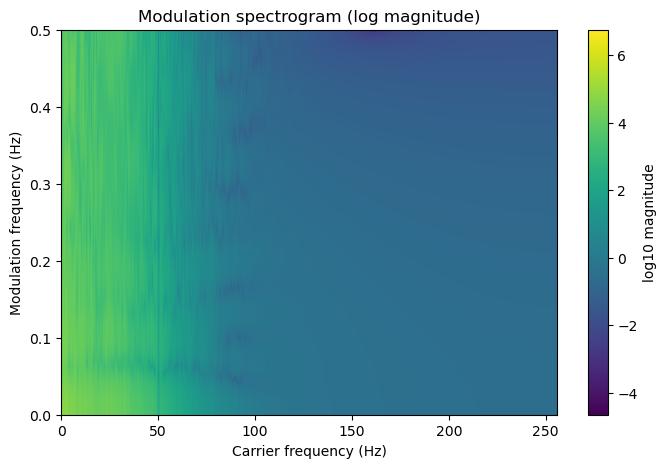

In [ ]:
# Plot modulation-spektrogram (log magnitude)
plt.figure(figsize=(8,5))
plt.imshow(np.log10(M+1e-12), aspect='auto', origin='lower', 
           extent=[f_car_plot[0], f_car_plot[-1], f_mod[0], f_mod[-1]])
plt.xlabel("Carrier frequency (Hz)")
plt.ylabel("Modulation frequency (Hz)")
plt.title("Modulation spectrogram (log magnitude)")
plt.colorbar(label="log10 magnitude")
plt.show()

## 8) Modulation-domain denoising

Vi anvender en enkel *soft mask* i modulationsdomænet og laver inverse STFT.


c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


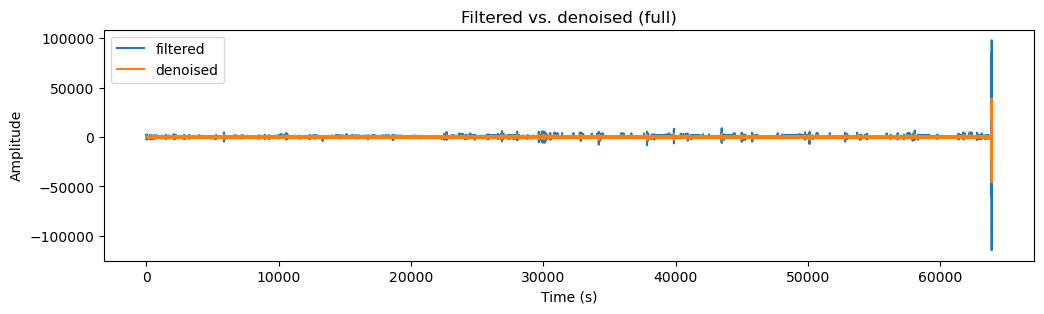

In [ ]:
x_d = modulation_denoise(x_f, fs)
plt.figure(figsize=(12,3))
plt.plot(t_all, x_f, label="filtered")
plt.plot(t_all, x_d, label="denoised")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Filtered vs. denoised (full)")
plt.legend()
plt.show()

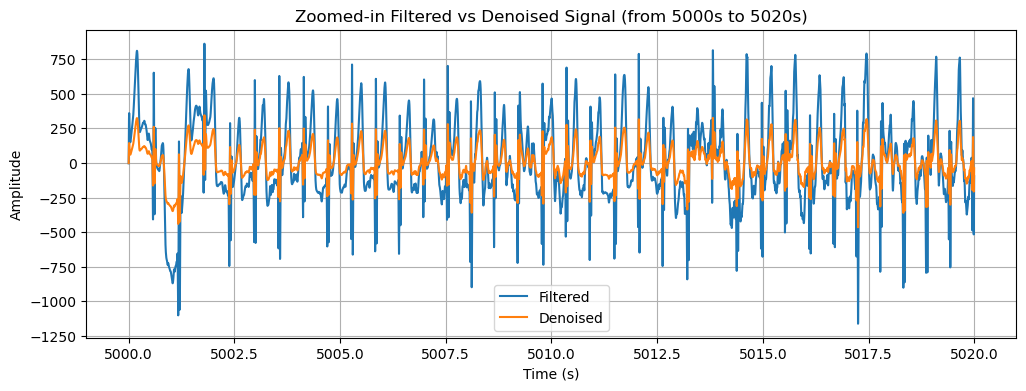

In [ ]:
# Extract the zoomed-in section for filtered and denoised signals
zoom_signal_filtered = x_f[int(zoom_start * fs):int(zoom_start * fs + zoom_L)]
zoom_signal_denoised = x_d[int(zoom_start * fs):int(zoom_start * fs + zoom_L)]

# Plot the zoomed-in section for filtered vs denoised signals
plt.figure(figsize=(12, 4))
plt.plot(zoom_t, zoom_signal_filtered, label="Filtered")
plt.plot(zoom_t, zoom_signal_denoised, label="Denoised")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Zoomed-in Filtered vs Denoised Signal (from {zoom_start}s to {zoom_end}s)")
plt.legend()
plt.grid()
plt.show()


## 9) R-peak detektion før/efter (sanity-check)

Vi bruger `neurokit2`'s detektor til at se, om denoising hjælper med peak-finding.


In [ ]:
import neurokit2 as nk

try:
    r_before = nk.ecg_peaks(x_f, sampling_rate=fs)[1].get("ECG_R_Peaks", [])
    r_after  = nk.ecg_peaks(x_d, sampling_rate=fs)[1].get("ECG_R_Peaks", [])
    print("R-peaks before:", len(r_before), "after:", len(r_after))
except Exception as e:
    print("R-peak detection error:", e)
    r_before, r_after = [], []

R-peaks before: 91776 after: 91776


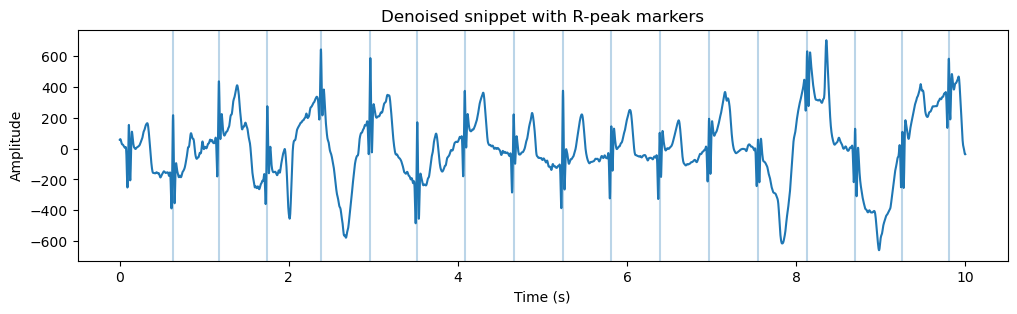

In [ ]:
# Plot et kort udsnit med R-peak markeringer efter denoising
sec = 10
L = int(sec*fs)
start = 0
end = min(N, start+L)
t = np.arange(start, end)/fs

plt.figure(figsize=(12,3))
plt.plot(t, x_d[start:end])
for rr in r_after:
    if start <= rr < end:
        plt.axvline(rr/fs, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Denoised snippet with R-peak markers")
plt.show()

## 10) Gem resultater

- `window_scores.csv` (klassiske SQI'er pr. vindue)
- `ekg_denoised.csv` (artefakt-reduceret spor)
- `run_summary.txt` (MSQI og R-peak counts)


In [ ]:
df_scores.to_csv(OUT_DIR / "window_scores.csv", index=False)
import pandas as pd
pd.DataFrame({"ekg_denoised": x_d}).to_csv(OUT_DIR / "ekg_denoised.csv", index=False)
with open(OUT_DIR / "run_summary.txt", "w") as f:
    f.write(f"MSQI_global: {msqi:.4f}\n")
    try:
        f.write(f"Rpeaks_before: {len(r_before)}   Rpeaks_after: {len(r_after)}\n")
    except:
        pass
print("Saved to:", OUT_DIR)

KeyboardInterrupt: 